# Lesson 1: What's your pet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Looking at the data

In [11]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [3]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images')]

In [5]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, ImageDataBunch.from_name_re gets the labels from the filenames using a regular expression.

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/mdasco/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [7]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [8]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64)
data.normalize(imagenet_stats)

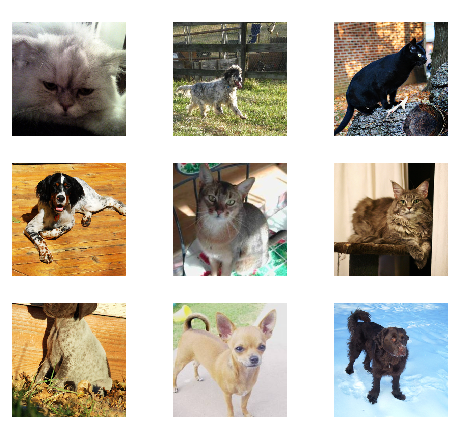

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier.

We will train for 4 epochs (4 cycles through all our data).

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\mdasco/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 18.8MB/s]


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.397227,0.355815,0.107578,02:12
1,0.589781,0.279270,0.092693,02:01
2,0.385052,0.251302,0.085927,02:01
3,0.281672,0.238709,0.075778,02:05


In [16]:
learn.save('stage-1')

## Results
Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

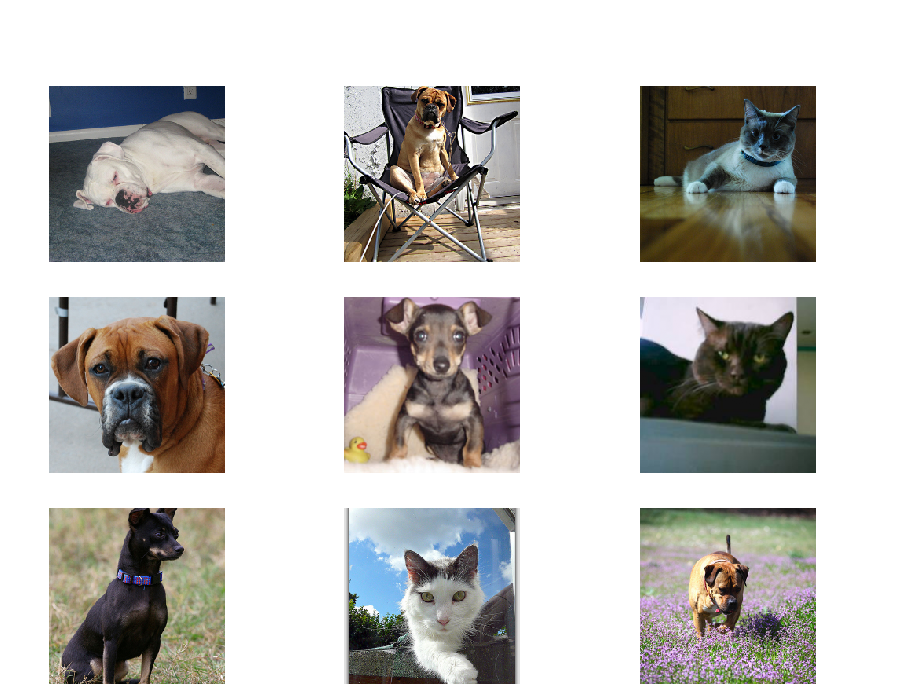

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interp.plot_top_losses)

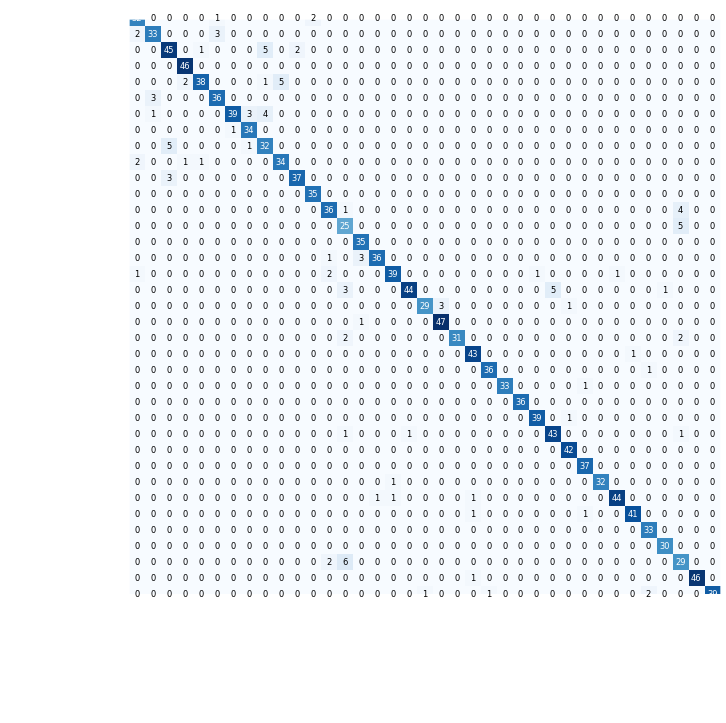

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Ragdoll', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Maine_Coon', 'Ragdoll', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Maine_Coon', 'Persian', 3),
 ('Siamese', 'Birman', 3),
 ('beagle', 'basset_hound', 3),
 ('chihuahua', 'american_pit_bull_terrier', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('boxer', 'american_bulldog', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2),
 ('german_shorthaired', 'staffordshire_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('yorkshire_terrier', 'sco

## Unfreezing, fine-tuning, and learning rates
Since our model is working as we expect it to, we will unfreeze our model and train some more.

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.708109,0.411121,0.127199,02:30


Reload the previously trained model

In [27]:
learn.load('stage-1');

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


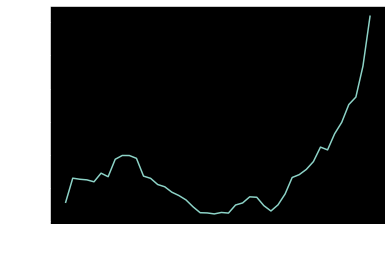

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.236654,0.228873,0.073072,03:34
1,0.231738,0.222033,0.073748,03:33


That's a pretty accurate model!